# Merton's portfolio problem
In this notebook we try to determine how to _optimally_ distribute your capital over 2 equity stocks and a bond with fix interest rate $r$.
We model Merton's portfolio problem using equity stocks of Google (`GOOGL`) and Tesla (`TSLA`), where we estimate the trends $\mu$ and
volatilities $\sigma$, which we fit to the _Black-Scholes_ model.

In order to measure _investor's_ utility, we used utility function $U(x) = \frac{x^{\gamma}}{\gamma}$. To find an optimal allocation
and maximalize expectation, we used dynamic programming principle and _Hamilton-Jacobi-Bellman_ equation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from libs.clients import AlphaVantage

In [2]:
client = AlphaVantage()
google = await client.get_time_series_daily("GOOGL", csv_format=True)
tesla = await client.get_time_series_daily("TSLA", csv_format=True)

The Blach-Scholes model for 2 stocks is:
$$dS^1_t = S^1_t(\mu_1dt + \sigma_{11}dW^1_t + \sigma_{12}dW^2_t)$$
$$dS^2_t = S^2_t(\mu_2dt + \sigma_{21}dW^1_t + \sigma_{22}dW^2_t)$$
with corresponding solution:
$$S^1 = S^1_0e^{(\mu^1 - \frac{\sigma_{11}^2 + \sigma_{12}^2}{3})t + \sigma_{11}W^1_t + \sigma_{12}W^2_t}$$
$$S^2 = S^2_0e^{(\mu^2 - \frac{\sigma_{21}^2 + \sigma_{22}^2}{3})t + \sigma_{21}W^1_t + \sigma_{22}W^2_t}$$

They can be written as: $dS_t = S_t(\mu -\frac{\Sigma}{2} +\sigma W)$.

With the exact solution: 

$$\begin{pmatrix} 
S^1_t\\
S^2_t 
\end{pmatrix} = 
\begin{pmatrix} 
S^1_0 & 0 \\
0 & S^2_0 
\end{pmatrix}
exp\Bigg\{ \Bigg(\begin{pmatrix} 
\mu_1 & 0 \\
0 & \mu_2 
\end{pmatrix}-\frac{\begin{pmatrix} 
\sigma_{11}^2 + \sigma_{12}^2 & 0 \\
0 & \sigma_{21}^2 + \sigma_{22}^2
\end{pmatrix}}{2}\Bigg)
\begin{pmatrix} 
t\\
t 
\end{pmatrix} + \begin{pmatrix} 
\sigma_{11} & \sigma_{12} \\
\sigma_{21} & \sigma_{22} 
\end{pmatrix} 
\begin{pmatrix} 
W_{t}^1\\
W_{t}^2 
\end{pmatrix}\Bigg\}$$

$$S^t = diag(S_0)e^{(diag(\mu)-\frac{\Sigma}{2})t + \sigma W_t}$$ 

where $\Sigma = diag(\sigma\sigma^T) = \begin{pmatrix} 
\sigma_{11}^2 + \sigma_{12}^2 & 0 \\
0 & \sigma_{21}^2 + \sigma_{22}^2
\end{pmatrix}$

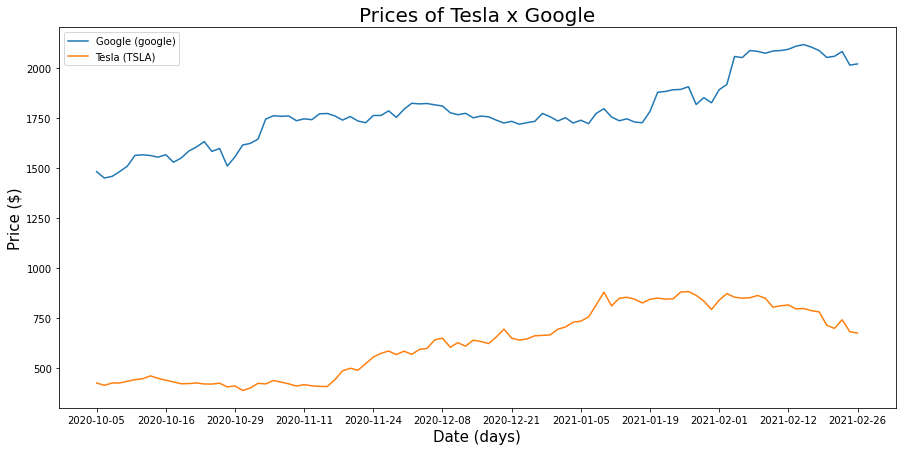

In [3]:
plt.figure(figsize=(15, 7))
plt.title("Prices of Tesla x Google", fontsize=20)
plt.plot(google["timestamp"][::-1], pd.to_numeric(google["close"][::-1]), label="Google (google)")
plt.plot(tesla["timestamp"][::-1], pd.to_numeric(tesla["close"][::-1]), label="Tesla (TSLA)")
plt.xticks([t for k, t in enumerate(tesla["timestamp"][::-1]) if k % 9 == 0])
plt.xlabel("Date (days)", fontsize=15)
plt.ylabel("Price ($)", fontsize=15)
plt.legend()
plt.show()

Our aim is to find the the maximal expected utility of our initial wealth $$\max_{\pi \in A} E[U(V_T)|V_0=1000]$$<br/>
In out case we have consider two stocks and possible investing in to bounds with rate r. The vectorised model:
$$dS_t = S_t(\mu+\sigma dW)$$
Then the wealth process is following:
$$dV_t = N^B_tdB_t + N^S_tdS_t = (1-\pi)^TV_t\frac{dB_t}{B_t} - cdt + \pi^T V_t\frac{dS_t}{S_t} = V_t((r+\pi^T(\mu+r) - c)dt + \pi\sigma dW_t)$$
Where as controls we consider $u = (\pi, c)$ where $\pi_t = (\pi_1, ..., \pi_n)^T$ and $\pi$ denotes fraction of the wealth invested in stock i, and $c$ stands for the consumption rate.<br/>
Investor consider a discounting factor $e^{-\beta t}$, $\beta > 0$. Then tries to maximize following cost function:
$$J(t,V,u) = E[\int_{t}^{T} e^{-\beta t}U(c)dt + e^{-\beta T}U(V_T^{\pi})]$$
For utility function $U(x) = \frac{x^\gamma}{\gamma}$ the optimal policy is:<br>

$c_t^* = e^\frac{-\beta t}{1-\gamma}h(t)^{-1}V_t$<br>

$\pi^* = \frac{\mu-r}{1-\gamma}(\sigma\sigma^T)^{-1}$<br>


<i><b>Sketch of the proof:</b></i> [1],[2]<br/>
Using the dynamic programming principle we obtain a differential operator:
$$\mathcal{L}^{(\pi,c)}v(t,x) = v_t(t,x) + ((r+\pi^T(\mu-r1)x-c)v_x(t,x) + \frac{1}{2}\pi^T\sigma\sigma^T\pi x^2v_{xx}(t,x)$$
then using the HJB equation: 
$$\sup_{\pi,c}\{e^{-\beta t}\frac{c^\gamma}{\gamma} + \mathcal{L}^{(\pi,c)}V(t,x) \} = 0$$
Where the corresponding maximalizers for c and $\pi$:<br/>

$c(t,x) = (e^{\beta t}V_x(t,x))^{\frac{1}{\gamma-1}}$<br/>

$\pi(t,x) = -(\sigma\sigma^T)^{-1}(\mu-r1)\frac{V_x}{xV_{xx}}$<br/>

Putting c and $\pi$ back to HJB equation we would get the optimal policy parameters $\pi^*$ and $c^*$:
$$\frac{1-\gamma}{\gamma}e^{\frac{-\beta t}{1-\gamma}}V_x^{\frac{\gamma}{\gamma-1}} + V_t + rxV_x - \frac{1}{2}(\mu -r1)^T(\sigma\sigma^T)^{-1}(\mu-r1)\frac{V_x^2}{V_{xx}}=0$$

$c_t^* = e^\frac{-\beta t}{1-\gamma}h(t)^{-1}V_t$<br>

$\pi^* = \frac{\mu-r}{1-\gamma}(\sigma\sigma^T)^{-1}$


_In our case, we do not consider a consumption parameter c (c=0)._

## The optimal policy and the maximal expected utility
Where $\alpha$ is the optimal strategy which corresponds to merton ratio: $\pi^* = \frac{\mu-r}{1-\gamma}(\sigma\sigma^T)^{-1}$ and $V_t$ is the total wealth at time t.

The wealth (the value of the portfolio) corresponds to following differentional equation:

$$dV_t = N^B_tdB_t + N^S_tdS_t = (1-\pi)^TV_t\frac{dB_t}{B_t} + \pi^T V_t\frac{dS_t}{S_t} = V_t((r+\pi^T(\mu+r))dt + \pi\sigma dW_t)$$

With corresponding solution: 

$$V_t = V_0e^{(r+\pi^T(\mu + r) - \frac{\pi^T\sigma\sigma^T\pi}{2})t + \pi\sigma dW_t}$$

Then the maximal expected utility: $$E(U(V_T)) = E(\frac{1}{\gamma}{(V_0e^{(r+\pi^T(\mu + r) - \frac{\pi^T\sigma\sigma^T\pi}{2})t + \pi^T\sigma dW_t})}^\gamma) = \frac{V_0^{\gamma}}{\gamma}e^{\frac{\gamma( r + \mu^T(\sigma\sigma^T)^{-1}r1)}{(1-\gamma)^2}}$$

For $r = 0$: $E(U(V_T)) = \frac{V_0^{\gamma}}{\gamma}e^{\frac{\gamma \mu^T(\sigma\sigma^T)^{-1}\mu}{2(1-\gamma)}}$

In [4]:
def merton_ratio(mu, sigma, r, gamma=.5):
    return (mu - r) / (1 - gamma) * np.linalg.inv(sigma * sigma.T)


def merton_allocation(merton_ratio, stocks, bonds, initial_wealth):
    inverse_merton_ratio = (1 - np.sum(merton_ratio))
    bonds_n = inverse_merton_ratio * initial_wealth / bonds[0]
    stocks_n = np.dot(1 / stocks[0], merton_ratio) * initial_wealth
    total_wealth = np.zeros(shape=time_horizon)
    total_wealth[0] = initial_wealth
    
    for i in range(1, time_horizon):
        total_wealth[i] = bonds_n * bonds[i] + np.dot(stocks[i], stocks_n.T)
        bonds_n = inverse_merton_ratio * total_wealth[i] / bonds[i]
        stocks_n = np.dot(1 / stocks[i], merton_ratio) * total_wealth[i]
        
    return total_wealth

In [5]:
time_horizon = len(google["timestamp"])
dt = 1
t = np.arange(0, time_horizon + 1, dt)

initial_capital = 10000
bond_0 = 1
interest_rate = 0.01
gamma = -0.8

google_mu = (float(google["close"].iloc[0]) - float(google["close"].iloc[-1])) / time_horizon
tesla_mu = (float(tesla["close"].iloc[0]) - float(tesla["close"].iloc[-1])) / time_horizon

google_volatility = pd.to_numeric(google["close"]).std() / (time_horizon - 1.)
tesla_volatility = pd.to_numeric(tesla["close"]).std() / (time_horizon - 1.)

mu = np.array([google_mu, tesla_mu])
sigma = np.array([[google_volatility, 0.0], [0.0, tesla_volatility]])

bonds = bond_0 * np.exp(interest_rate / 200 * t)
stocks = np.array([pd.to_numeric(google["close"][::-1]), pd.to_numeric(tesla["close"][::-1])]).T

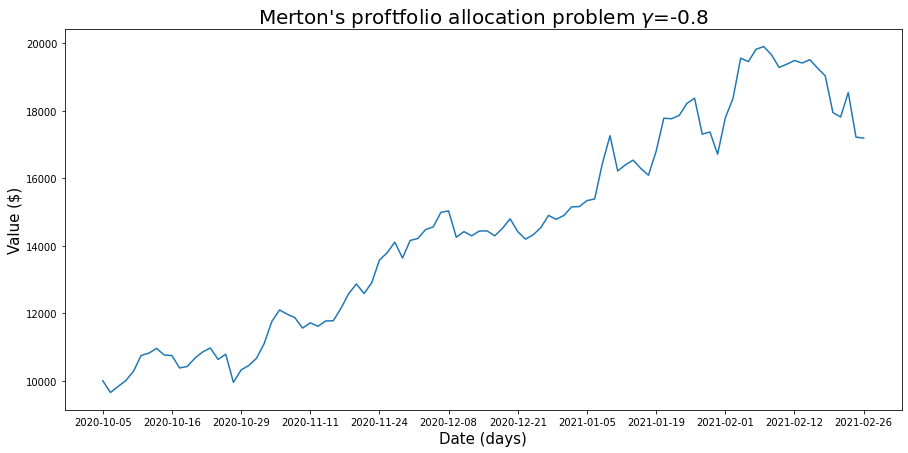

In [6]:
ratio = merton_ratio(mu, sigma, interest_rate, gamma)
merton_portfolio_value = merton_allocation(ratio, stocks, bonds, initial_capital)

plt.figure(figsize=(15, 7))
plt.title(f"Merton's proftfolio allocation problem $\gamma$={gamma}", fontsize=20)
plt.plot(google["timestamp"][::-1], merton_portfolio_value)
plt.xticks([t for k, t in enumerate(google["timestamp"][::-1]) if k % 9 == 0])
plt.xlabel("Date (days)", fontsize=15)
plt.ylabel("Value ($)", fontsize=15)
plt.show()

Optimal allocation for Google and Tesla stocks

In [37]:
np.diagonal(ratio)

array([1.02598932, 0.47053414])

## Choosing a right $\gamma$
The parameter $\gamma \in (-\infty,0) \cup (0,1)$, therefore, we can look closely on three limiting values of $\gamma$'s interval:
 - $\gamma \to -\infty$:
 In this case the investor doesn't like risk - he is not risking at all. He puts his all initial wealth into bounds.
 - $\gamma \to 0$: 
 In this case the investor plays optimally - he balances the amount of money into stocks and bonds.
 - $\gamma \to 1$: 
 In this case the investor likes risk - he is risking all his money (and not only his money, he is also borrowing from bank to invest into stocks).

In [ ]:
x1 = np.arange(.01, 0.9, .01)
gammas_positive = np.zeros(89)
for k, g in enumerate(x1):
    r = merton_ratio(mu, sigma, interest_rate, g)
    gammas_positive[k] = merton_allocation(r, stocks, bonds, initial_capital)[-1]
    
x2 = np.arange(-10, -0.01, .01)
gammas_negative = np.zeros(999)
for k, g in enumerate(x2):
    r = merton_ratio(mu, sigma, interest_rate, g)
    gammas_negative[k] = merton_allocation(r, stocks, bonds, initial_capital)[-1]

In order to demonstrate how our initial wealth is invested and what are realised outcomes in the end of the invested period,
we plotted realised wealth for (positive) $\gamma \in (0, 0.9)$ and (negative)  $\gamma \in (-10, -0)$.

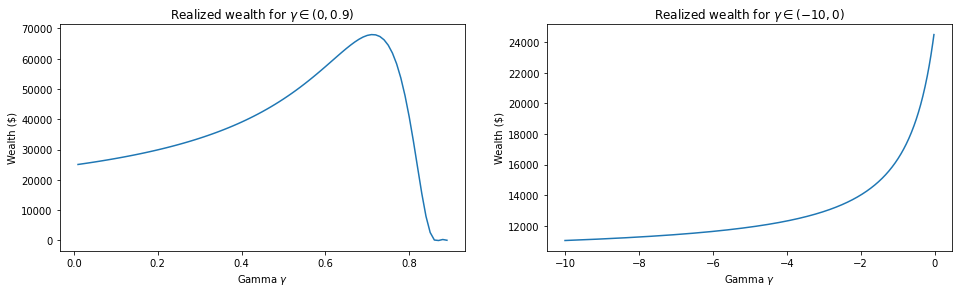

In [36]:
plt.figure(figsize=(16, 10))
plt.subplots_adjust(hspace=0.4)
plt.subplot(221)
plt.title("Realized wealth for $\gamma \in (0, 0.9)$")
plt.xlabel("Gamma $\gamma$")
plt.ylabel("Wealth ($)")
plt.plot(x1, gammas_positive)

plt.subplot(222)
plt.title("Realized wealth for $\gamma \in (-10, 0)$")
plt.xlabel("Gamma $\gamma$")
plt.ylabel("Wealth ($)")
plt.plot(x2, gammas_negative)

plt.show()

## References
[1] Tikosi, K. (2016), _Merton’s Portfolio Problem_, http://www.etd.ceu.edu/2016/tikosi_kinga.pdf  
[2] Jonsson, M., Sircar, R. (2001) _Optimal Investment Problems and Volatility Homogenization Approximations_, https://www.princeton.edu/~sircar/Public/ARTICLES/montreal.pdf 
[3] Hull, J. (2002). _Options, futures, and other derivatives_ Boston: Prentice Hall  
[4] Hult, H. & Lindskog, F. (2007) _Mathematical Modeling and Statistical Methods for Risk Management_, 
[https://people.kth.se/~lindskog/papers/RMlecturenotes07B.pdf](https://people.kth.se/~lindskog/papers/RMlecturenotes07B.pdf)  
[5] Alpha Vantage, (2017-2021), _Alpha Vantage API Documentation_, https://www.alphavantage.co/documentation/ 